## 소개
이 노트북은 학습 모델을 앙상블(결합)하는 방법, 특히 스태킹(stacking)이라고 알려진 앙상블 기법의 변형에 대해 매우 기본적이고 간단한 소개를 하고 있습니다. 간략하게 말하자면, 첫 번째 레벨(base)에서 사용되는 스태킹은 몇 가지 기본 분류기를 통해 예측을 수행한 다음 두 번째 레벨에서 다른 모델을 사용해 첫 번째 레벨에서 나온 예측 결과를 다시 예측합니다. 

타이타닉 데이터세트는 Kaggle의 많은 신규 사용자들이 접하는 데이터셋임과 동시에 스태킹 개념을 도입한 첫 번째 후보 데이터셋입니다. 스태킹 기법이 Kaggle 대회들에 있어서 많은 우승 팀의 주요 솔루션으로 쓰였음에도 이 주제에 대한 커널이 많이 부족하기 때문에, 이 노트북이 그 공백을 어느 정도 채울 수 있기를 바랍니다. 

저 또한 Kaggle 초보자입니다. 그럼에도 제가 기회를 만들고 공부할 수 있게 해 준 앙상블/스태킹 스크립트는 AllState Severity Claims 대회에서 우수한 성적을 거둔 Faron이 만들었습니다. 이 노트북의 내용은 Faron의 스크립트로부터 타이타닉 문제가 분류기들에 대한 앙상블임을 고려하여 이식되었지만 Faron은 회귀를 위한 앙상블을 작업했습니다. 여기에서 Faron의 스크립트를 확인할 수 있습니다 : 

[Stacking Starter](https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867) : by Faron

여러분들이 이 노트북을 통해 앙상블의 정의와 개념을 잘 전달받기를 바랍니다. 아래에서 언급할 앙상블 기법을 구현한 다른 독립형 kaggle 스크립트는 Public LB 점수가 0.808로 상위 9%였으며 4분 이내에 실행됩니다. 그럼에도 불구하고 저는 이 스크립트를 개선하고 추가할 여지가 많다는 것을 확신합니다. 제가 어떻게 더 향상했으면 좋겠는지에 대한 의견을 남겨 주십시오. 

In [15]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.svm import SVC

## Feature Exploration, Engineering and Cleaning
이제부터 우리는 대부분의 커널들이 진행하는 것처럼 진행할 것입니다. 먼저 손에 들고 있는 데이터를 탐색하고 가능한 feature engineering 방법들에 대해 확인하고 수치적으로 모든 범주형 특징(categorical features)들을 인코딩할 것입니다. 

In [2]:
# Load in the train and test datasets
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


범주형 자료에서 어떤 식으로든 정보를 추출하는 것이 놀라운 일은 아닙니다. 
Sina는 feature engineering에 대한 매우 포괄적이고 잘 구성된 노트북을 갖고 있습니다. 그의 작업물을 확인해 보십시오. 

[Titanic Best Working Classfier](https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier) : by Sina

In [3]:
full_data = [train, test]

# Some features of my own that I have added in Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# 승객이 타이타닉 호에서 객실을 배정받았는지 알려주는 lambda함수를 통해 Has_Cabin이라는 feature를 만듭니다. 
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# 아래는 Sina의 노트북으로부터 가져온 Feature Engineering 단계들입니다.

# SibSp와 Parch를 합쳐 FamilySize라는 새 feature를 만듭니다. 
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# FamilySize로부터 IsAlone이라는 새로운 feature를 만듭니다. 
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Embarked 열에 존재하는 모든 NULL값들을 제거합니다. 
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Fare 열에 존재하는 NULL값을 모두 제거하고 CategoricalFare라는 새로운 feature를 만듭니다. 
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# CategoricalAge이라는 새로운 feature를 만듭니다. 
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# 승객 이름에서 칭호를 추출하는 함수를 정의합니다. 
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# 승객들의 호칭을 담고 있는 새로운 피쳐, Title을 만듭니다. 
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# 잘 알려지지 않은 나머지 호칭들은 "Rare"이라는 그룹으로 묶습니다. 
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                                 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

좋습니다. features를 정리하고 연관 있는(relevant) 정보들을 추출한 후 카테고리 열(categorical columns)들을 삭제했으므로 우리가 갖고 있는 features는 모두 숫자형 자료여야 합니다. 숫자형 자료는 우리의 기계 학습 모델들에 적합한 형식입니다. 그러나 진행하기에 앞서 변경된 데이터셋에 대한 간단한 상관 관계 및 분포표를 그려 보도록 하겠습니다. 

## 시각화

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


### 피어슨 상관관계 히트맵(Pearson Correlation Heatmap)

우리는 이제부터 몇 가지 상관 관계 플롯을 생성하여 서로 연관된 feaures끼리 어떻게 나타나는지 살펴볼 것입니다. 그러기 위해 Seaborn 패키지를 활용해 히트맵을 다음과 같이 매우 편리하게 그려 볼 수 있습니다. 

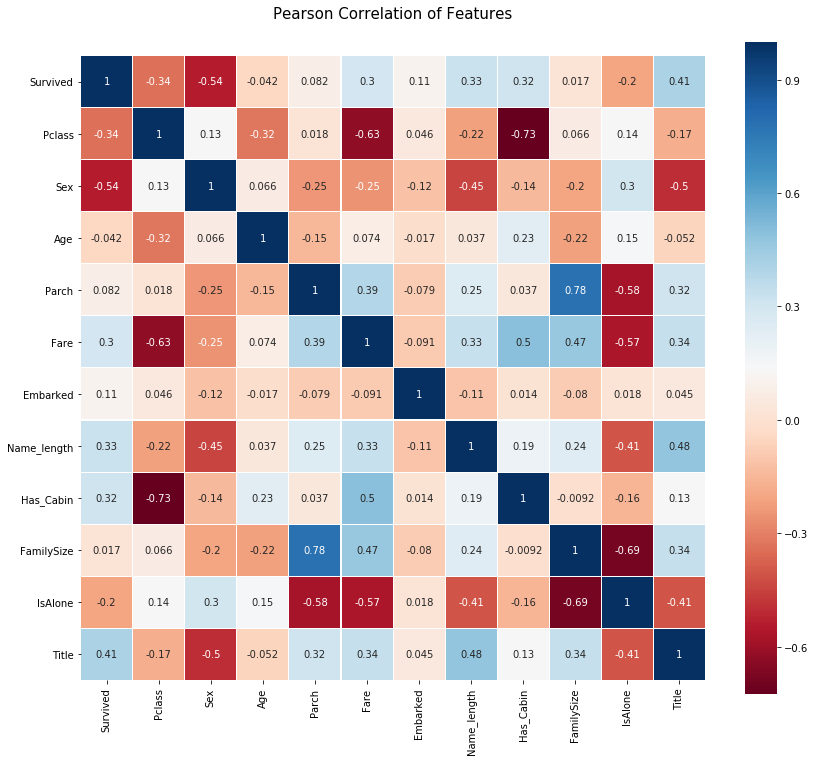

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### 플롯으로부터 얻을 수 있는 점

피어슨 상관관계 플롯에서 우리는 서로 강하게 연관된 features가 많지 않다는 것을 알 수 있습니다. 이는 모델을 학습할 때 중복되거나 불필요한 데이터가 없기 때문에 모델에 features를 넣어 주기 좋으며, 무엇보다 각 feature에 고유한 정보들이 포함되어 있어 다행입니다. Family Size(가족 크기) 및 Parch(부모 및 자녀 수) 두 feature는 서로 강하게 연관되어 있습니다. 연습을 위해 이 두 feature는 모두 남겨 놓도록 하겠습니다

### 쌍을 이루는 플롯 그리기(Pairplots)
마지막으로 하나의 feature가 다른 feature에 대해 갖는 데이터 분포를 관찰하기 위해 몇 개의 쌍 플롯(Pairplots)을 그려 보도록 하겠습니다. 다시 한번 우리는 Seaborn을 사용할 것입니다. 

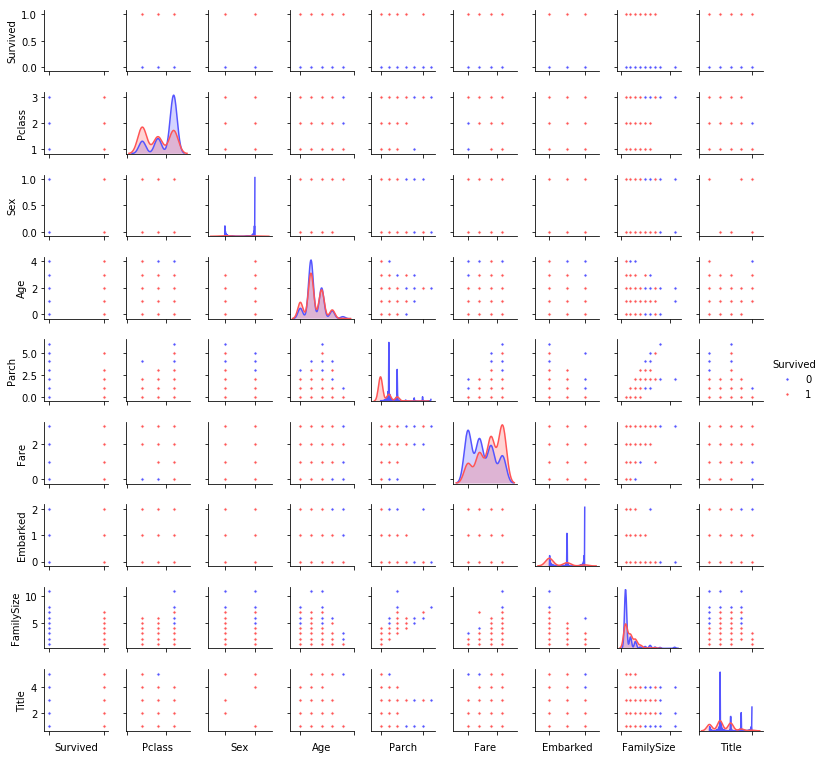

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

## Ensembling & Stacking models
간단하게 feature eigineering을 수행해본 후 우리는 마침내 이 노트북의 핵심에 도달했습니다. 이제 스태킹 앙상블을 만들어 봅시다!

### Helpers via Python Classes
여기서부터는 파이썬 클래스를 활용해 보다 편리한 작업을 할 수 있도록 하겠습니다. 프로그래밍을 처음 시작하는 사람은 일반적으로 객체 지향 프로그래밍(Object Oriented Programming, OOP)과 함께 사용되는 클래스라는 개념에 대해 들어보았을 것입니다. 클래스는 객체 생성을 위한 코드/프로그램이며, 해당 클래스에 대한 특정한 함수 및 메소드를 구현하는 데 도움을 줍니다. 
(* 역자 주: '클래스'는 '자동차'에, '메소드 또는 함수'는 '자동차를 구성하는 다양한 기능'들이라고 묘사할 수 있습니다. 자동차라는 클래스는 핸들 조향 기능, 가속 기능, 정지 기능과 같은 다양한 함수들을 포함하고 있습니다. 또한 자동차 클래스를 오토바이라는 새로운 클래스에 상속하면 이제 오토바이 클래스는 조향 기능, 가속 기능, 정지 기능을 상속받아 사용할 수 있게 됩니다.)

아래의 코드 섹션에서는 Sklearn이 제공하는 모든 분류기들에 공통된 inbuilt methods(train, predict, fit과 같이 분류기가 내장하고 있는 함수들)를 확장할 수 있는 SklearnHelper 클래스를 작성할 것입니다. 따라서 5개의 다른 분류기를 호출하려면 동일한 메소드를 5번 반복해서 작성할 필요가 없으므로 중복성이 없어집니다. 

In [17]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

TypeError: __init__() got an unexpected keyword argument 'n_folds'

여기서는 여러분께서 이미 알고 있더라도 파이썬에서 객체나 클래스를 사용하는 게 익숙하지 않은 분들을 위해 양해를 부탁드리겠습니다. 위에서 타이핑한 코드에 대해 설명해 드리겠습니다. 기본 분류기를 만들 때 Sklearn 라이브러리에 이미 들어 있는 모델만 사용할 것이므로 우리는 이것을 클래스로 확장할 수 있습니다. 

<b>def init</b> : 클래스의 기본 생성자를 호출하는 파이썬 표준입니다. 즉 객체(여기서는 분류기가 객체입니다)를 만들기 위해서는 clf(원하는 sklearn 분류기), seed(랜덤값을 만들기 위한 초기값) 및 params(분류기 학습을 위한 파라미터)를 지정해야 합니다. 

나머지 코드는 단순히 sklearn 분류기들에 존재하는 train 메소드를 호출하는 SklearnHelper 클래스의 메소드들입니다. 기본적으로 다양한 Sklearn 분류기들을 확장하는 래퍼(참조) 클래스를 만들어 스태커(Stacking 앙상블을 위한 객체)에 여러 학습 모델들을 구현해 쌓을 때 동일한 코드를 반복 작성해야 하는 부담을 줄여 줍니다. 

### Out-of-Fold Predictions
소개 섹션에서 언급한 것처럼, 스태킹은 기본 분류기의 예측을 두 번째 레벨 모델의 학습을 위한 입력으로 사용합니다. 그러나 첫 번째 레벨의 모델을 학습할 때 단순히 전체 학습 데이터를 사용하여 학습을 진행하면 안됩니다. 모델이 전체 테스트셋에 대한 예측값을 만들고 그것을 두 번째 레벨 학습에 사용할 수 있기 때문입니다. 이렇게 하면 첫 번째 단계 모델이 테스트셋을 이미 "보았기" 때문에 예측 결과에 위험이 따르게 됩니다. 따라서 이러한 결과물을 이용해 두 번째 레벨 모델 학습에 넣어주게 되면 오버피팅을 유발하게 됩니다. 

In [18]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## 첫 번째 단계의 모델들을 생성하기
이제부터 다섯 가지의 분류기를 첫 번째 단계 학습을 위해 준비하겠습니다. 이 모델들은 모두 Sklearn 라이브러리를 통해 편리하게 호출할 수 있으며, 우리가 사용할 분류기의 종류는 다음과 같습니다. 

- 1. Random Forest Classifier
- 2. Extra Trees Classifier
- 3. AdaBoost Classifier
- 4. Gradient Boosting Classifier
- 5. Support Vector Machine

#### 인자(파라미터) 소개
매개 변수들에 대한 간단한 요약만 말씀드리겠습니다. 

- <b>n_jobs</b> : 학습 과정에 사용될 (CPU)코어 개수입니다. -1로 설정하면 모든 코어가 사용됩니다. 
- <b>n_estimators</b> : 학습 모델의 분류 트리 개수입니다. (기본값은 10개로 설정됩니다.)
- <b>max_depth</b> : 트리의 최대 깊이 또는 노드의 확장 정도를 의미합니다. 지나치게 많은 수를 설정하면 트리가 너무 깊어지며 과적합(Overfitting)할 수 있습니다. 
- <b>verbose</b> : 학습 과정 중 텍스트를 출력할지 여부를 조정합니다. 값을 0으로 주면 모든 텍스트를 출력하지 않는 반면 값 3은 모든 학습 이터레이션 중 트리 학습 프로세스에 대한 텍스트를 출력합니다. 

Sklearn 공식 웹 사이트를 통해 보다 자세한 설명을 확인하시기 바랍니다. 다른 유용한 파라미터가 있음을 확인하실 수 있을 것입니다. 

In [19]:
# 위에서 언급한 분류기들에 파라미터를 넣는 과정입니다. 

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

위에서 객체지향 프로그래밍의 프레임워크 내에서 객체와 클래스에 대해 언급하였듯, 앞서 정의한 Helper Sklearn 클래스를 통해 다섯 가지의 분류기를 담고있는 5개의 객체를 생성해 보겠습니다.

In [20]:
# 다섯 개의 분류기를 담고 있는 다섯 개의 객체 생성하기
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

#### Train 데이터와 Test 데이터로부터 Numpy 배열 만들기
좋습니다. 첫 번째 레벨의 기본 모델 객체를 준비한 후 다음과 같이 원래의 판다스 데이터프레임에서 Numpy 배열을 생성해 학습을 위한 Train과 Test 데이터를 준비할 수 있습니다. 

In [21]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

#### 첫 번째 레벨의 예측값 구하기 
이제 다섯 개의 첫 번째 레벨 분류기에 Train과 Test 데이터를 넣어 주고 앞서 정의한 Out-of-Fold 예측 함수를 사용해 첫 번째 레벨의 예측값을 구해 봅니다. 아래 코드는 실행에 시간이 다소 걸리므로 몇 분 정도 기다려 주십시오. 

In [22]:
# Out-of-Fold train과 test 예측값을 만듭니다. 이 과정을 통해 생성된 예측값은 새로운 feature로서 사용됩니다. 
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

NameError: name 'kf' is not defined

#### 다양한 분류기로부터 생성된 Feature Importance
이제 첫 번째 레벨 분류기들의 학습을 마쳤으므로 Sklearn 모델들의 매우 멋진 기능을 활용할 수 있습니다. 이는 매우 간단한 코드 한 줄만으로 Train 및 Test 세트에서 다양한 features를 출력하는 것입니다. 

Sklearn 공식 문서에 따르면 대부분의 분류기들은 단순히 .featureimportances를 입력하는것 만으로도 feature importance를 반환하도록 작성되었습니다. 그러므로 우리는 함수 earliand를 사용하여 매우 유용한 feature를 뽑고 그려 볼 것입니다. 

In [23]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.11378685 0.23939312 0.03310431 0.01936289 0.04903556 0.02178041
 0.11150843 0.06601307 0.06938738 0.01135292 0.26527506]
[0.11960862 0.37936651 0.02800249 0.01722223 0.05600911 0.02806993
 0.0478471  0.08539648 0.04411977 0.02173994 0.17261781]
[0.028 0.012 0.022 0.07  0.036 0.01  0.684 0.012 0.052 0.004 0.07 ]
[0.08775042 0.01105894 0.05509658 0.01200437 0.04635933 0.02630692
 0.17412528 0.03671658 0.11462991 0.00656284 0.42938884]


우리는 아직 feature importance를 할당하고 저장하는 방법을 알지 못합니다. 따라서 위의 코드에서 예측값을 출력하고 아래에서처럼 파이썬 List 자료형에 복사할 것입니다. (지루한 팁에 대해서 양해 부탁드립니다.)

In [24]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

Ploty 패키지를 통해 쉽게 그래프를 그릴 수 있도록 feature importance가 들어 있는 List로부터 판다스 데이터프레임을 만듭니다. 

In [25]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

#### Ploty Scatterplots를 통해 Interactive feature importance 불러오기
여기서 대화형 Ploty 패키지를 사용하여 다음과 같이 'Scatter'를 호출해 여러 분류기로부터 얻은 feature importance를 ploty scatter plot으로 시각화합니다. 

In [26]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

이제 모든 feature importance의 평균을 계산하고 데이터프레임에 새로운 열(column)로 저장합니다.

In [27]:
# 값들의 평균을 포함하는 새 열(column)을 만듭니다.

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


#### 평균 feature importance의 Ploty Barplot 그리기 
모든 분류기에서 평균 featue importance를 얻은 다음 이를 다음과 같이 ploty가 제공하는 barplot 형태로 그릴 수 있습니다. 

In [28]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## 첫번째 단계의 예측값들을 통해 두 번째 단계의 예측값 뽑기
#### 첫 번째 단계 결과물을 새로운 feature로서 사용하기
첫 번째 단계로부터 예측값들을 얻었으므로 이제 다음 분류기들을 위한 새로운 feature들의 집합을 구축하는 것을 생각해 볼 수 있습니다. 아래 코드처럼 이전 분류기들로부터 첫 번째 단계의 예측값들을 새 열(column)로 가져오고 이를 통해 다음 분류기들을 학습할 수 있습니다. 

In [29]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

NameError: name 'rf_oof_train' is not defined

#### 두 번째 단계의 train 세트에 대한 상관관계 히트맵(correlation heatmap) 그려보기

In [30]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

NameError: name 'base_predictions_train' is not defined

서로 관련성이 없는 훈련된 모델들을 사용하면 더 좋은 점수를 얻는 것에 유리하다는 기사들과 Kaggle 우승자들의 후기가 있습니다. 

In [31]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

NameError: name 'et_oof_train' is not defined

첫 번째 단계의 train과 test 예측값들을 연결(concatenate)하여 x_train과 x_test로 연결했으므로, 이제 우리는 두 번째 단계의 학습 모델들의 학습을 진행해 볼 수 있습니다.

### XGBoost 분류기를 이용한 두 번째 단계 모델 학습
이 단계에서 우리는 boosted tree 학습 모델을 위한 매우 유명한 라이브러리인 XGBoost를 선택할 것입니다. XGBoost는 대규모의 boosted tree 알고리즘을 위해 개발되었습니다. 알고리즘에 대한 자세한 설명은 공식 문서를 확인하십시오. 

어쨌든 우리는 XGBClassifier를 호출하고 첫 번째 단계의 train과 target 데이터에 적합(fit)시킬 것입니다. 그리고 학습이 끝난 모델로 다음과 같이 예측을 수행할 것입니다:

In [32]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

모델에서 사용된 XGBoost 매개 변수들에 대해 빠르게 설명하겠습니다. 

- max_depth : tree를 얼마나 키울지 결정합니다. 지나치게 높으면 과적합을 유발합니다.
- gamma : tree의 leaf 노드(맨 마지막)에서 추가 파티션을 만드는 데 필요한 minimum loss reduction입니다. 클수록 더 보수적인(안전한) 알고리즘이 될 것입니다. 
- eta : 과적합(overfitting)을 방지하기 위해 각 부스팅 단계에서 사용되는 스텝 사이즈 감소량입니다. 

#### 제출을 위한 파일 생성하기
마지막으로, 훈련된 모든 첫 번째 단계 및 두 번째 단계의 모델을 통해 Titanic 대회에 제출할 적절한 형식으로 예측값을 출력해 봅니다. 

In [33]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

#### 추가 개선 단계

지금까지 앙상블 스태커를 제작하는 아주 간단한 방법을 보여 주었습니다. Kaggle 대회에서 가장 높은 순위에서는 괴상한 stacked classifiers의 조합 뿐만 아니라 두 단계 이상까지도 가는 스태킹도 사용하고 있습니다. 

점수를 향상시키기 위해 할 수 있는 몇 가지 추가 단계는 다음과 같습니다:
- 1. 최적의 매개 변수 값을 찾기 위해 모델을 학습할 때 Cross-validation(교차 검증)을 사용할 수도 있습니다. 
- 2. 학습에 보다 다양한 기본 모델들을 사용하십시오. 결과가 더 관련성이 없을수록 더 좋은 최종 결과를 보여줍니다. 

### 결론
이 노트북은 학습 모델들을 쌓기(stacking) 위한 스크립트를 소개하고 있습니다. 다시한번 Faron과 Sina에게 고마움을 표합니다. 

스태킹이나 앙상블 기법에 대한 다른 훌륭한 자료는 MLWave:[Kaggle Ensembling Guide](http://mlwave.com/kaggle-ensembling-guide/)를 참고하십시오. 

다음에 또 뵙겠습니다. 